In [1]:
from sklearn import cross_validation
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

titanic = pd.read_csv('D:\RomiCode\DataScience\Datasets\Titanic\\train.csv', header=0)
titanic_test = pd.read_csv('D:\RomiCode\DataScience\Datasets\Titanic\\test.csv', header=0)
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]

titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())
# Replace all the occurences of male with the number 0.
titanic.loc[titanic["Sex"] == "male", "Sex"] = 0
# Replace all the occurences of female with the number 1.
titanic.loc[titanic["Sex"] == "female", "Sex"] = 1

titanic["Embarked"] = titanic["Embarked"].fillna("S")
titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 0
titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 1
titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 2

# Repeat with test dataset
titanic_test["Age"] = titanic_test["Age"].fillna(titanic["Age"].median())
titanic_test["Fare"] = titanic_test["Fare"].fillna(titanic_test["Fare"].median())
titanic_test.loc[titanic_test["Sex"] == "male", "Sex"] = 0 
titanic_test.loc[titanic_test["Sex"] == "female", "Sex"] = 1
titanic_test["Embarked"] = titanic_test["Embarked"].fillna("S")

titanic_test.loc[titanic_test["Embarked"] == "S", "Embarked"] = 0
titanic_test.loc[titanic_test["Embarked"] == "C", "Embarked"] = 1
titanic_test.loc[titanic_test["Embarked"] == "Q", "Embarked"] = 2


# Generating a familysize column
titanic["FamilySize"] = titanic["SibSp"] + titanic["Parch"]
titanic_test["FamilySize"] = titanic_test["SibSp"] + titanic_test["Parch"]

# The .apply method generates a new series
titanic["NameLength"] = titanic["Name"].apply(lambda x: len(x))
titanic_test["NameLength"] = titanic_test["Name"].apply(lambda x: len(x))

C:\Users\Romi\Anaconda3\envs\Default\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


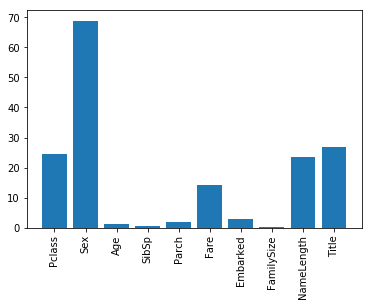

In [2]:
# A function to get the title from a name.
def get_title(name):
    # Use a regular expression to search for a title.  Titles always consist of capital and lowercase letters, and end with a period.
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

# Get all the titles
titles = titanic["Name"].apply(get_title)
# Map each title to an integer.  Some titles are very rare, and are compressed into the same codes as other titles.
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, "Col": 7, "Mlle": 8, "Mme": 8, "Don": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
for k,v in title_mapping.items():
    titles[titles == k] = v

# Add in the title column.
titanic["Title"] = titles

titles_test = titanic["Name"].apply(get_title)
for k,v in title_mapping.items():
    titles_test[titles_test == k] = v
titanic_test["Title"] = titles
    
    
predictors = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "FamilySize", "NameLength", "Title"]

# Perform feature selection
selector = SelectKBest(f_classif, k=5)
selector.fit(titanic[predictors], titanic["Survived"])

# Get the raw p-values for each feature, and transform from p-values into scores
scores = -np.log10(selector.pvalues_)

# Plot the scores.  See how "Pclass", "Sex", "Title", and "Fare" are the best?
plt.bar(range(len(predictors)), scores)
plt.xticks(range(len(predictors)), predictors, rotation='vertical')
plt.show()


titanic['Sex'] = titanic['Sex'].astype(int)
titanic['Embarked'] = titanic['Embarked'].astype(int)
titanic['Title'] = titanic['Title'].astype(int)

In [3]:
    
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


predictors = ["Pclass", "Sex", "Age", "Fare", "Embarked", "FamilySize", "NameLength", "Title"]

titanic_test['Sex'] = titanic_test['Sex'].astype(int)
titanic_test['Embarked'] = titanic_test['Embarked'].astype(int)
titanic_test["Title"] = titanic_test["Title"].astype(int)
train_X = titanic[predictors]
test_X = titanic_test[predictors]
train_y = titanic["Survived"]

gbm = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1).fit(train_X, train_y)
predictions = gbm.predict(train_X)


accuracy = sum(predictions[predictions == titanic["Survived"]]) / len(predictions)
print(accuracy)

#print(gbm.feature_importances_)
xgb.plot_importance(gbm)

predictions = gbm.predict(test_X)

submission = pd.DataFrame({ 'PassengerId': titanic_test['PassengerId'],
                            'Survived': predictions })
submission.to_csv("submission.csv", index=False)

0.331088664422


This is another part

Parameter Tuning

max depth

I usually start with shallow trees (max depth 3). I prefer to use shallow trees because they dont tend to overfit. I tried increasing the max depth to 4 and 5, but that made the scores worse for public lb. So I stuck to using max depth 3.

min_child_weight

Initially, I set the min_child_weight to 1000 because of the high number of data points. Later I moved it to 1500 and 500 and saw that 500 gave me a better score. Decreasing further to 300 didnt help so I stuck with 500.

Learning Rate, num_rounds and early stopping

I set up the early stopping parameter to 50, i.e. if the eval score doesnt improve in 50 rounds, stop training further. The learning rate was initially set to 0.05 and num rounds were initially set to 1500. But this was very slow and the score was improving even after 1500 rounds. So I changed the learning rate to 0.2 and reduced the num rounds to 800. This gave me stopping near the 600th round and quicker training as a result.